In [1]:
# %pip install resampy
# %pip install tqdm
# %pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical


2024-11-29 21:09:34.053630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 21:09:34.199687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732894774.274982    4464 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732894774.295794    4464 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 21:09:34.460981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
audio_file_path = "./Dataset/"

In [4]:
def visualize(audio_file_path, Tag):
    ad, sr = librosa.load(audio_file_path)

    spec = np.abs(librosa.stft(ad))
    spec = librosa.amplitude_to_db(spec, ref=np.max)

    mel_spect = librosa.feature.melspectrogram(y=ad, sr=sr)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

    chroma = librosa.feature.chroma_cqt(y=ad, sr=sr, bins_per_octave=36)

    mfcc = librosa.feature.mfcc(y=ad, sr=sr)

    fig, ax = plt.subplots(5, 1, figsize=(10, 15), constrained_layout=True)
    fig.suptitle(f'Visualization of {Tag} audio', fontsize=16)

    ax[0].plot(ad)
    ax[0].set_title(f'{Tag} audio Waveform')

    img = librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log', ax=ax[1])
    fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
    ax[1].set_title(f'{Tag} audio spectrogram')

    img = librosa.display.specshow(mel_spect, sr=sr, x_axis='time', y_axis='mel', ax=ax[2])
    fig.colorbar(img, ax=ax[2], format="%+2.0f dB")
    ax[2].set_title(f'{Tag} audio Mel Spectrogram')

    img = librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', ax=ax[3])
    fig.colorbar(img, ax=ax[3], format="%+2.0f dB")
    ax[3].set_title(f'{Tag} audio Chroma')

    img = librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax[4])
    fig.colorbar(img, ax=ax[4], format="%+2.0f dB")
    ax[4].set_title(f'{Tag} audio MFCC')

    plt.show()

In [5]:
demo_audio_paths = os.path.join(audio_file_path, 'DEMO')

for item in os.listdir(demo_audio_paths):
    if item.find("original") != -1:
        real_audio_path = os.path.join(demo_audio_paths, item)
    else:
        fake_audio_path = os.path.join(demo_audio_paths, item)

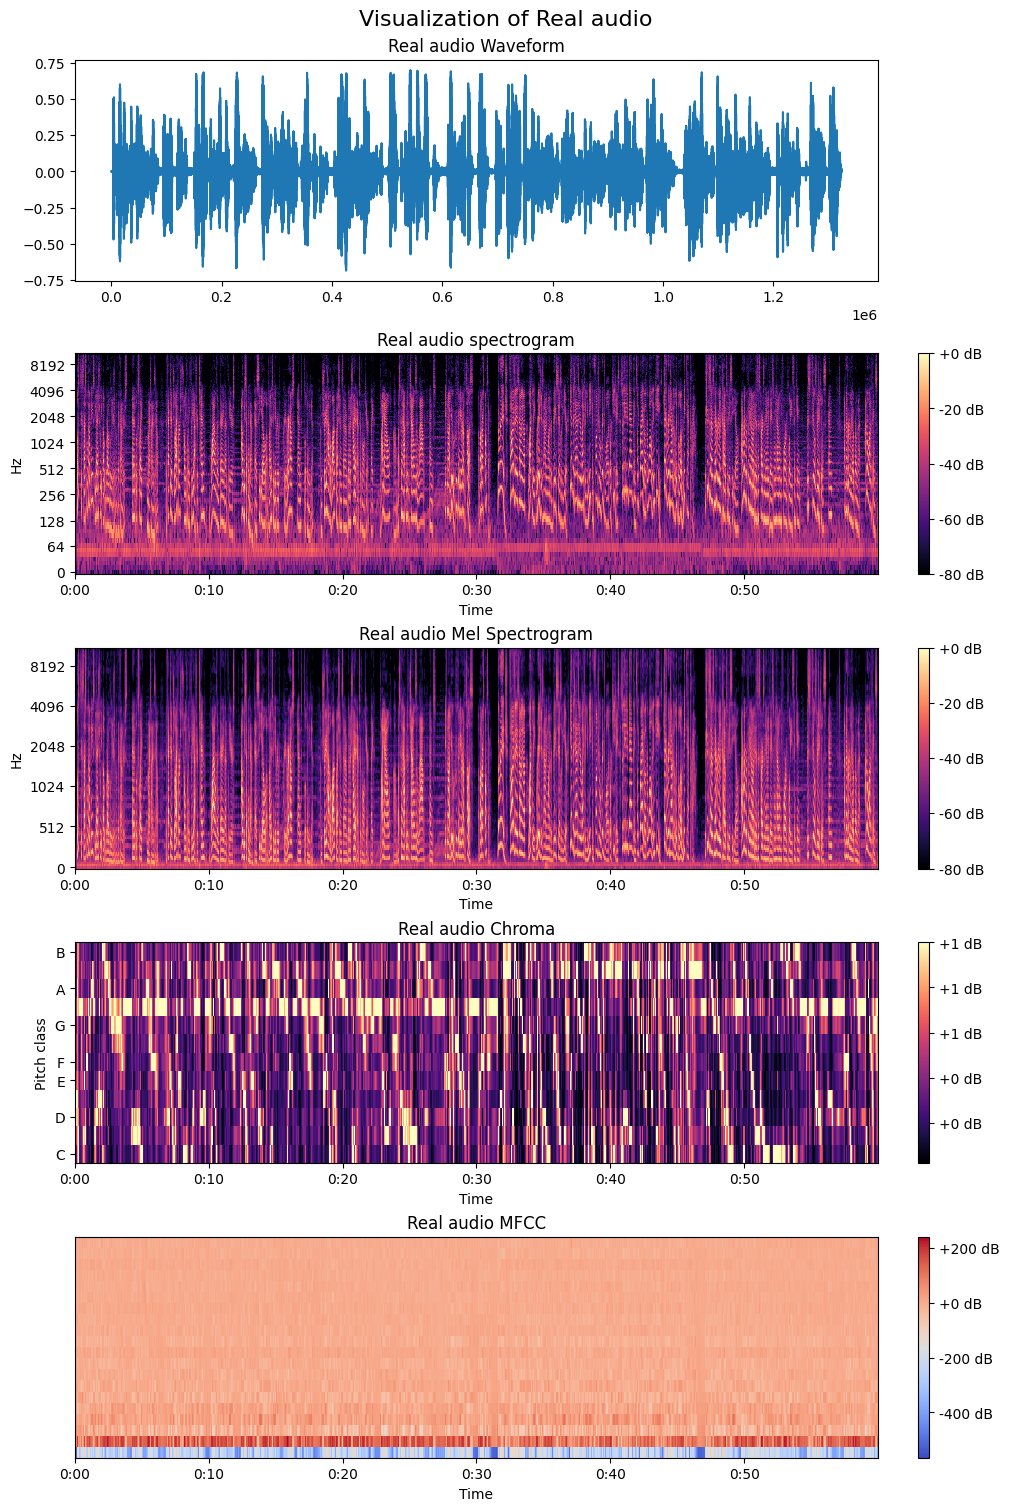

In [6]:
visualize(real_audio_path, "Real")

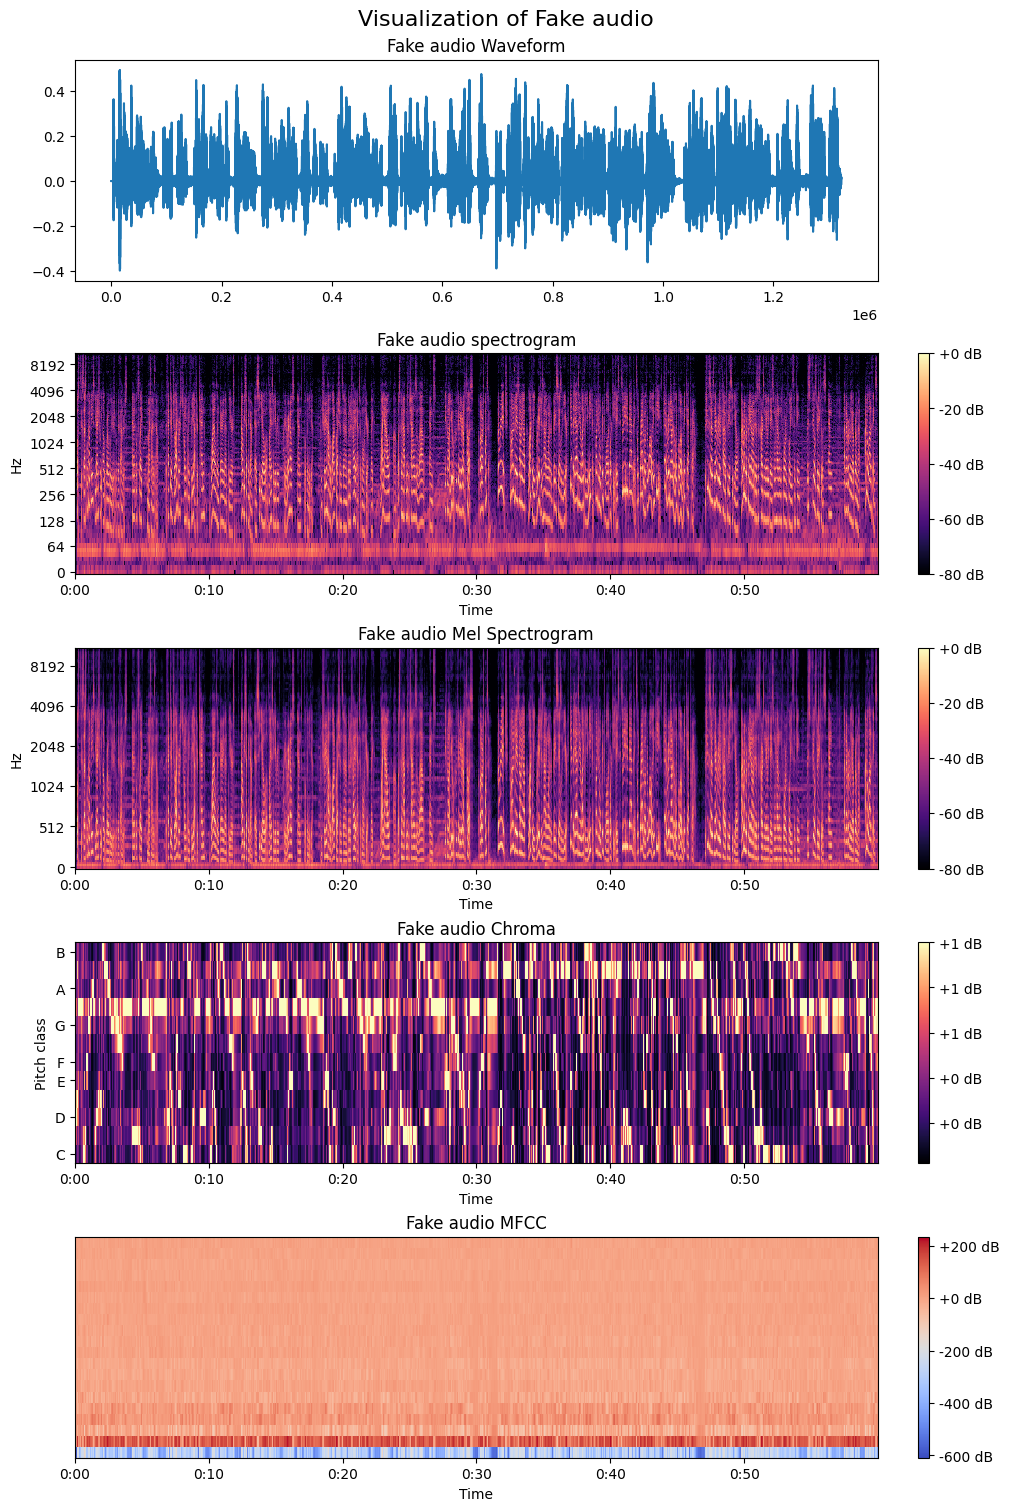

In [7]:
visualize(fake_audio_path, "Fake")

In [8]:
data, labels = [], []

folders = ['FAKE', 'REAL']

for folder in folders:
    files = os.listdir(os.path.join(audio_file_path, folder))

    for file in tqdm(files):
        file_path = os.path.join(audio_file_path, folder, file)
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')
        mfcc_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfcc_features_scaled = np.mean(mfcc_features.T, axis=0)

        data.append(mfcc_features_scaled)
        labels.append(folder)

100%|██████████| 8/8 [00:48<00:00,  6.10s/it]


In [9]:
feature_df = pd.DataFrame({'features': data, 'labels': labels})
print(feature_df.head())
print(feature_df['labels'].value_counts())

                                            features labels
0  [-272.24997, 91.887726, -16.733953, 5.9313335,...   FAKE
1  [-257.93683, 64.86041, -25.226696, 10.45378, -...   FAKE
2  [-349.3125, 74.14648, -17.648634, 1.6684374, -...   FAKE
3  [-343.21475, 85.65895, -15.256305, 3.4466329, ...   FAKE
4  [-280.45615, 52.155453, -12.677328, 23.328798,...   FAKE
labels
FAKE    56
REAL     8
Name: count, dtype: int64


In [10]:
def label_encoder(labels):
    le = LabelEncoder().fit(labels)
    print(labels.name, le.classes_)
    return le.transform(labels)

feature_df['labels'] = label_encoder(feature_df['labels'])

labels ['FAKE' 'REAL']


In [11]:
X = np.array(feature_df.features.tolist())
y = np.array(feature_df.labels.tolist())

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
y_resampled = to_categorical(y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
num_labels = len(feature_df['labels'].unique())
input_shape = feature_df['features'][0].shape

print(f"Input shape : {input_shape}")
print(f"Number of labels : {num_labels}")

Input shape : (40,)
Number of labels : 2


In [12]:
model = Sequential([
    Dense(128, input_shape=input_shape),
    Activation("relu"),
    Dropout(0.5),
    Dense(256),
    Activation("relu"),
    Dropout(0.5),
    Dense(128),
    Activation("relu"),
    Dropout(0.5),
    Dense(num_labels),
    Activation("softmax")
])

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

/home/bhanu/IITH/Fourth Year/AI5063/SAI-DBASTS/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-29 21:16:05.864127: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,426 (279.01 KB)

 Trainable params: 71,426 (279.01 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, y_train, batch_size=2, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3750 - loss: 24.1604 - val_accuracy: 0.4348 - val_loss: 2.3087
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5694 - loss: 14.0752 - val_accuracy: 0.3478 - val_loss: 4.2157
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5097 - loss: 15.9208 - val_accuracy: 0.7391 - val_loss: 0.8885
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3769 - loss: 16.2675 - val_accuracy: 0.6522 - val_loss: 1.4208
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5540 - loss: 9.1386 - val_accuracy: 0.3478 - val_loss: 7.9430
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6621 - loss: 6.9997 - val_accuracy: 0.6522 - val_loss: 0.6605
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5085 - loss: 6.9830 - val_accuracy: 0.3478 - val_loss: 1.4482
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5551 - loss: 6.3364 - val_accuracy: 0.6522

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test loss : {test_loss}")
print(f"Test accuracy : {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9565 - loss: 0.1199
Test loss : 0.11994989961385727
Test accuracy : 0.95652174949646


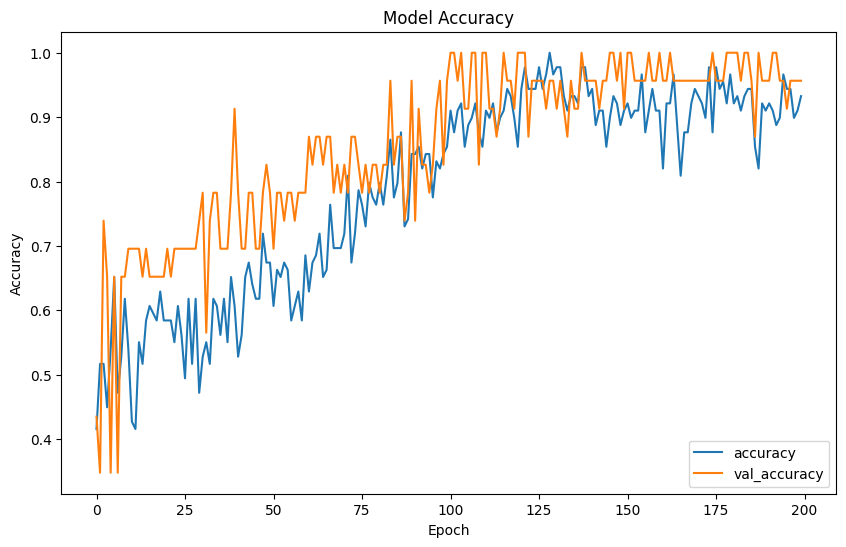

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')
plt.show()

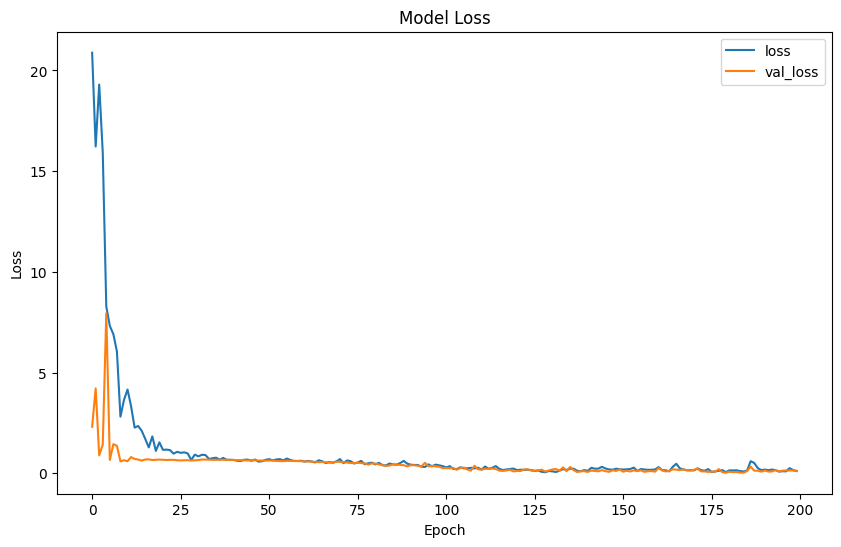

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')
plt.show()

In [17]:
def predict(audio_file_path, model):
    audio, sr = librosa.load(audio_file_path, res_type='kaiser_fast')
    mfcc_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfcc_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfcc_features_scaled = np.expand_dims(mfcc_features_scaled, axis=0)
    prediction = model.predict(mfcc_features_scaled)

    print(f"Prediction : {folders[np.argmax(prediction[0])]}")

In [18]:
real_path = '../Speaker_Identification/combined_files/Benjamin_Netanyau_combined.wav'
predict(real_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction : REAL


In [19]:
currTime = pd.Timestamp.now().strftime("%Y%m%d%H%M")
model.save(f'weights/anti-spoof-{currTime}.keras')